In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Import Libraries##


In [ ]:
# Data manipulation and processing
import numpy as np
import pandas as pd
from collections import defaultdict

# Text processing and NLP
import re
import string
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# %matplotlib inline

# Machine Learning and Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score,recall_score,f1_score,classification_report,accuracy_score,confusion_matrix,roc_curve,auc)
from keras.models import Sequential
from keras.layers import (LSTM,Embedding,BatchNormalization,Dense,TimeDistributed,Dropout,Bidirectional,Flatten,GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Load Datasets##

In [ ]:
train_dataset = pd.read_csv("/content/drive/MyDrive/Disaster Tweets/train.csv", encoding="latin-1")
test_dataset = pd.read_csv("/content/drive/MyDrive/Disaster Tweets/test.csv", encoding="latin-1")

In [ ]:
train_dataset

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
test_dataset

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


##Handling Missing Values##

In [ ]:
print(train_dataset.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [ ]:
train_dataset = train_dataset.dropna(how="any", axis=1)
train_dataset['text_len'] = train_dataset['text'].apply(lambda x: len(x.split(' ')))

train_dataset

,id,text,target,text_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17
...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,11
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,20
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8
7611,10872,Police investigating after an e-bike collided ...,1,19


##EDA##


In [ ]:
balance_counts = train_dataset.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271])

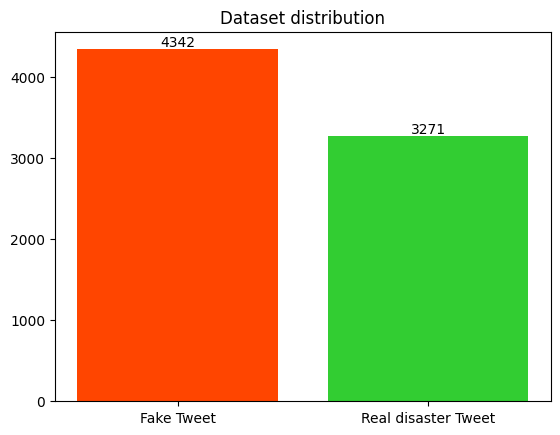

In [ ]:
x = ['Fake Tweet', 'Real disaster Tweet']
y = [balance_counts[0], balance_counts[1]]
colors = ['#FF4500', '#32CD32']

# Create figure and bar chart with colors
fig, ax = plt.subplots()
bars = ax.bar(x, y, color=colors)
# Adding text labels on bars
for bar, value in zip(bars, y):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # Position x of the text
        bar.get_height(),                   # Position and of the text (above the bar)
        f'{value}',                         # Text with the value
        ha='center', va='bottom'            # Horizontal and vertical alignment
    )
plt.title('Dataset distribution')
plt.show()

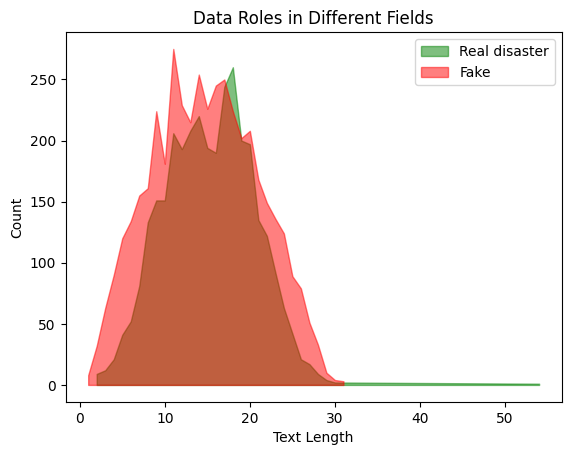

In [ ]:
# Filtering and counting the length of texts for each category
disaster = train_dataset[train_dataset['target'] == 1]['text_len'].value_counts().sort_index()
fake = train_dataset[train_dataset['target'] == 0]['text_len'].value_counts().sort_index()

# Create the figure and axes
fig, ax = plt.subplots()

# Plot lines with filled areas
ax.fill_between(disaster.index, disaster.values, alpha=0.5, label='Real disaster', color='green')
ax.fill_between(fake.index, fake.values, alpha=0.5, label='Fake', color='red')

ax.set_title('Data Roles in Different Fields')
ax.set_xlabel('Text Length')
ax.set_ylabel('Count')
ax.legend()
plt.show()

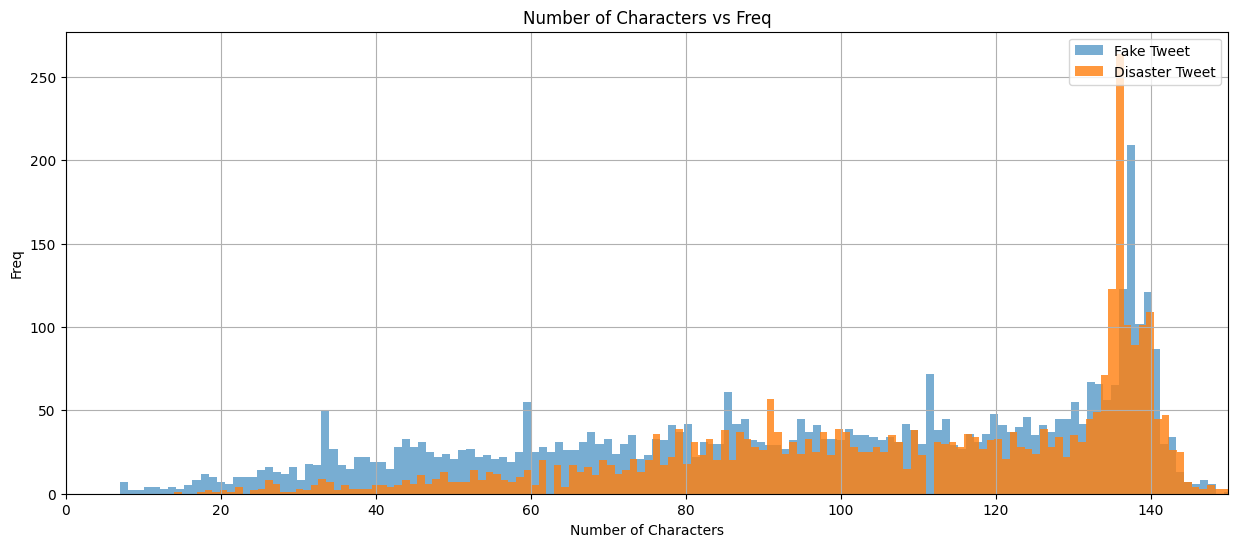

In [ ]:
def length(text):
    return len(text)

train_dataset['c_length'] = train_dataset['text'].apply(length)

plt.rcParams['figure.figsize'] = (15.0, 6.0)
bins = 150
plt.hist(train_dataset[train_dataset['target'] == 0]['c_length'], alpha = 0.6, bins=bins, label='Fake Tweet')
plt.hist(train_dataset[train_dataset['target'] == 1]['c_length'], alpha = 0.8, bins=bins, label='Disaster Tweet')
plt.title('Number of Characters vs Freq')
plt.xlabel('Number of Characters')
plt.ylabel('Freq')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

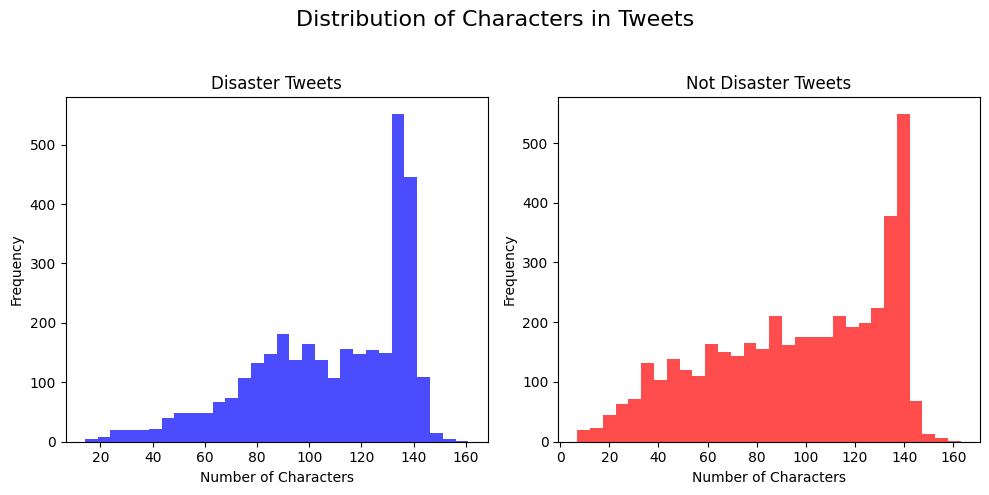

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram for disaster tweets
tweet_len = train_dataset[train_dataset['target'] == 1]['text'].str.len()
ax1.hist(tweet_len, color='blue', bins=30, alpha=0.7)
ax1.set_title('Disaster Tweets')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Frequency')

# Histogram for non-disaster tweets.
tweet_len = train_dataset[train_dataset['target'] == 0]['text'].str.len()
ax2.hist(tweet_len, color='red', bins=30, alpha=0.7)
ax2.set_title('Not Disaster Tweets')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')


fig.suptitle('Distribution of Characters in Tweets', fontsize=16)

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##Preprocessing Dataset##

Remove words that do not provide information

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

In [ ]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        r'['
        u'\U0001F600-\U0001F64F'  # Emoticons
        u'\U0001F300-\U0001F5FF'  # Symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # Transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # Flags (iOS)
        u'\U00002702-\U000027B0'  # Miscellaneous symbols
        u'\U000024C2-\U0001F251'  # Other symbols
        ']+',
        flags=re.UNICODE
    )
    return emoji_pattern.sub('', text)

In [ ]:
def remove_html_tags(text):
    html_pattern = re.compile(r'<.*?>|&(?:[a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return html_pattern.sub('', text)

In [ ]:
def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [ ]:
def preprocess_text(input_text):
  # replace abbreviations with their long form
    cleaned_text = str(input_text)
    cleaned_text = re.sub(r"\bI'm\b", "I am", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\byou're\b", "you are", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bthey're\b", "they are", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bcan't\b", "cannot", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bwon't\b", "will not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bdon't\b", "do not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bdoesn't\b", "does not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bain't\b", "am not", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bwe're\b", "we are", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bit's\b", "it is", cleaned_text, flags=re.IGNORECASE)

    cleaned_text = re.sub(r"&gt;", ">", cleaned_text)
    cleaned_text = re.sub(r"&lt;", "<", cleaned_text)
    cleaned_text = re.sub(r"&amp;", "&", cleaned_text)

    # Correction of common errors and relevant abbreviations
    cleaned_text = re.sub(r"\bw/\b", "with", cleaned_text)  # "w/" → "with"
    cleaned_text = re.sub(r"\blmao\b", "laughing my ass off", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"<3", "love", cleaned_text)  # Corazón → "love"
    cleaned_text = re.sub(r"\bph0tos\b", "photos", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\bamirite\b", "am I right", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\btrfc\b", "traffic", cleaned_text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r"\b16yr\b", "16 year", cleaned_text)

    cleaned_text = str(cleaned_text).lower()  # Convert to lowercase

    # Remove unwanted patterns
    cleaned_text = re.sub(r'\[.*?\]', '', cleaned_text)  # Remove content inside brackets
    cleaned_text = re.sub(r'\n', ' ', cleaned_text)  # Replace newlines with spaces
    cleaned_text = re.sub(r'\w*\d\w*', '', cleaned_text)  # Remove words with numbers

    cleaned_text = remove_urls(cleaned_text)  # Remove URLs
    cleaned_text = remove_emojis(cleaned_text)  # Remove emojis
    cleaned_text = remove_html_tags(cleaned_text)  # Remove HTML tags
    cleaned_text = remove_punctuation(cleaned_text)  # Remove punctuation

    return cleaned_text

In [ ]:
# Download resources needed for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

stop_words_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()  # <-- We use lemmatizer

# Add additional context-specific words
extra_stop_words = ['u', 'im', 'r']  # Common abbreviations
extra_stop_words2 = [
    'u', 'im', 'r', 'ur', 'pls', 'thx',  # Common abbreviations
    'b4', 'omw', 'ppl', 'msg', 'lvl',    # Fast communication
    'sos', '911', 'help', 'asap',        # Emergencies
    'wtf', 'omg', 'idk', 'nvm',          # Emotional reactions
    'brb', 'btw', 'lmk', 'imo',          # Rapid coordination
    'stay', 'safe', 'evacuate', 'fyi'    # Indications and recommendations
]

all_stop_words = stop_words_list + extra_stop_words + extra_stop_words2 # Combine both stop word lists
word_stemmer = nltk.SnowballStemmer("english") # Create a SnowballStemmer object for English language

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def process_tweet_content(tweet):
    cleaned_tweet = preprocess_text(tweet) # Clean up text by removing URLs, punctuation, HTML, etc.
    processed_tweet = ' '.join(lemmatizer.lemmatize(word) for word in cleaned_tweet.split() if word not in stop_words_list) # Eliminating stopwords and applying lemmatization instead of stemming

    return processed_tweet

In [ ]:
train_dataset['text_clean'] = train_dataset['text'].apply(process_tweet_content)
train_dataset

,id,text,target,text_len,c_length,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,22,133,resident asked shelter place notified officer ...
3,6,"13,000 people receive #wildfires evacuation or...",1,9,65,people receive wildfire evacuation order calif...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17,88,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,11,83,two giant crane holding bridge collapse nearby...
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,20,125,ariaahrary thetawniest control wild fire calif...
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,65,volcano hawaii
7611,10872,Police investigating after an e-bike collided ...,1,19,137,police investigating ebike collided car little...


In [ ]:
test_dataset['text_clean'] = test_dataset['text'].apply(process_tweet_content)
test_dataset

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...,earthquake safety los angeles âãã safety fa...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm ri worse last hurricane city hardest hit...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo


##Corpus##

In [ ]:
def build_corpus_from_df(dataframe, target_value):
    #Build a corpus of words from the given dataframe based on the target value.
    corpus = []

    # Filter tweets by target value and split into words.
    for words in dataframe[dataframe['target'] == target_value]['text_clean'].str.split():
        for word in words:
            corpus.append(word)

    return corpus

In [ ]:
disaster_corpus = build_corpus_from_df(train_dataset, 1)
word_frequency = defaultdict(int) # Initializing a dictionary to count word frequency
# Counting the frequency of each word in the corpus of disaster tweets.
for word in disaster_corpus:
    word_frequency[word] += 1

top_words = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[:10] # Sort the words by frequency in descending order and take the 10 most frequent ones
top_words # Display the 10 most frequent words

[('fire', 262),
 ('news', 136),
 ('via', 121),
 ('disaster', 118),
 ('california', 115),
 ('year', 112),
 ('suicide', 110),
 ('people', 106),
 ('police', 106),
 ('u', 105)]

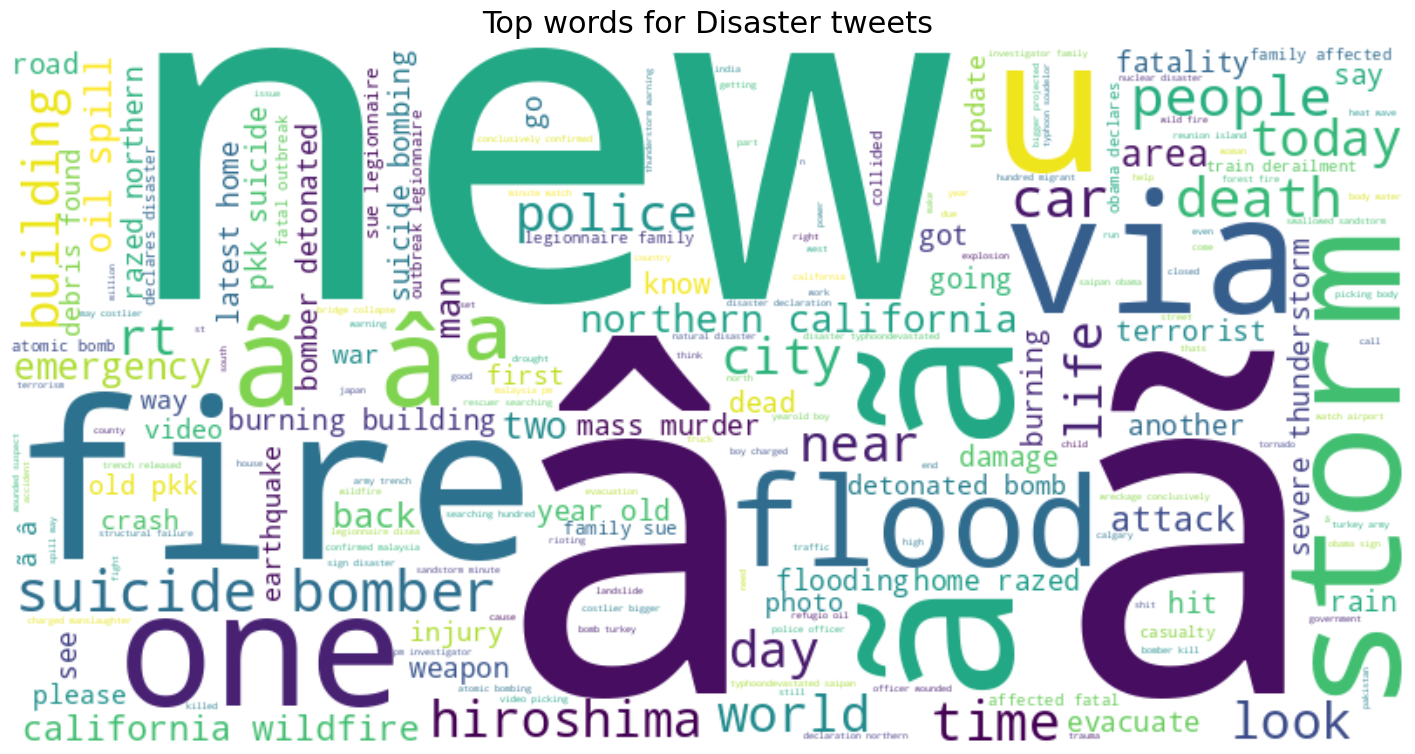

In [ ]:
wc = WordCloud( background_color='white', max_words=200, width=800, height=400)  # Adjust image size, max words


text = ' '.join(train_dataset.loc[train_dataset['target'] == 1, 'text_clean']) # Generate word cloud with real disaster tweets.
wc.generate(text)

# Configuring and displaying the word cloud
plt.figure(figsize=(18, 10))
plt.title('Top words for Disaster tweets',fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
print(wc.words_.keys())

dict_keys(['â ã', 'new', 'fire', 'ã ã', 'u', 'via', 'storm', 'one', 'flood', 'ã âª', 'suicide bomber', 'car', 'people', 'death', 'time', 'police', 'look', 'building', 'day', 'world', 'rt', 'life', 'hiroshima', 'near', 'city', 'today', 'northern california', 'emergency', 'area', 'two', 'oil spill', 'man', 'back', 'attack', 'california wildfire', 'burning building', 'damage', 'fatality', 'suicide bombing', 'flooding', 'say', 'go', 'year old', 'hit', 'bomber detonated', 'got', 'dead', 'know', 'burning', 'terrorist', 'home razed', 'rain', 'see', 'road', 'another', 'weapon', 'going', 'evacuate', 'severe thunderstorm', 'mass murder', 'latest home', 'razed northern', 'pkk suicide', 'detonated bomb', 'earthquake', 'first', 'injury', 'ã â', 'old pkk', 'photo', 'update', 'crash', 'please', 'way', 'war', 'video', 'debris found', 'family sue', 'sue legionnaire', 'legionnaire family', 'family affected', 'affected fatal', 'fatal outbreak', 'outbreak legionnaire', 'casualty', 'collided', 'atomic bomb

In [ ]:
corpus_disaster_tweets_fake = build_corpus_from_df(train_dataset, 0)

dic=defaultdict(int)
for word in corpus_disaster_tweets_fake:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('like', 255),
 ('get', 185),
 ('new', 168),
 ('u', 145),
 ('one', 136),
 ('body', 116),
 ('time', 103),
 ('love', 100),
 ('via', 99),
 ('would', 97)]

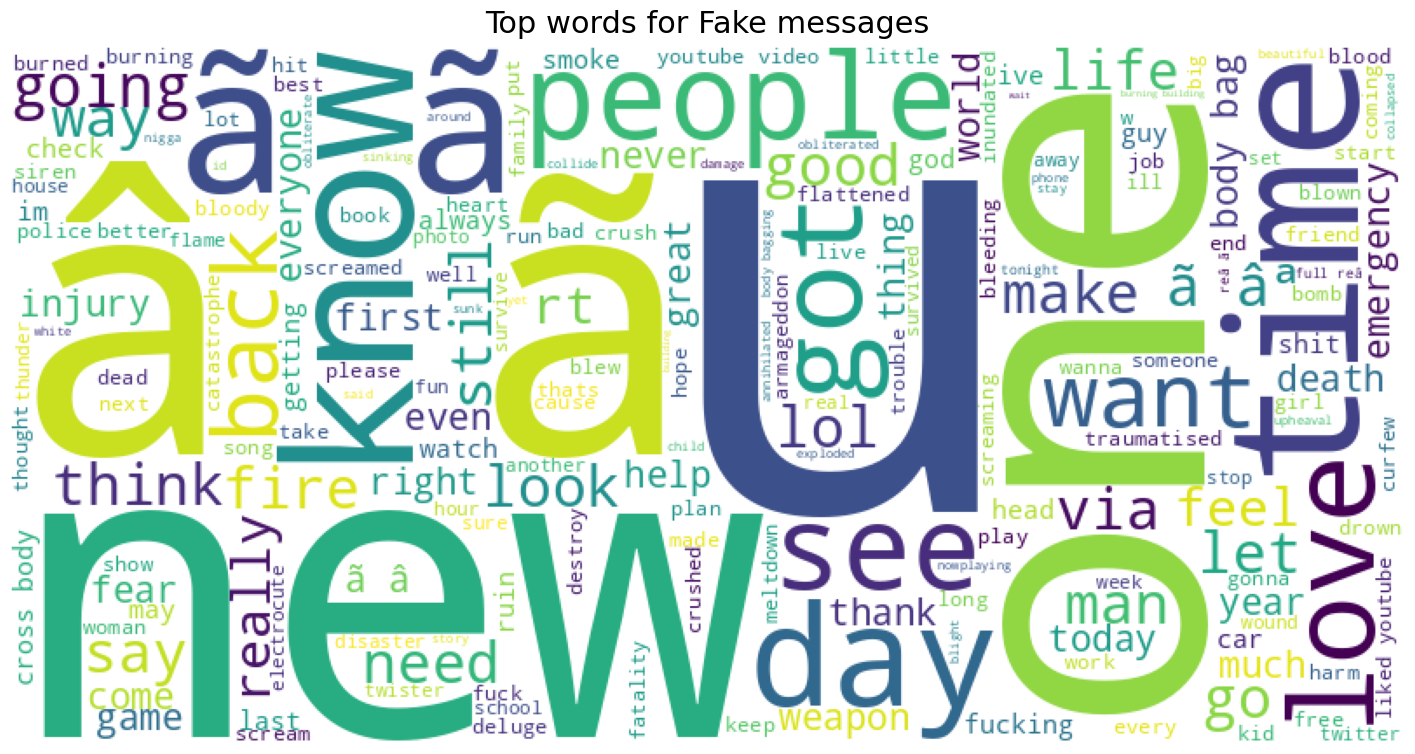

In [ ]:
wc2 = WordCloud(background_color='white',max_words=200,width=800,height=400)
wc2.generate(' '.join(text for text in train_dataset.loc[train_dataset['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Fake messages',fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc2)
plt.axis("off")
plt.show()

In [ ]:
print(wc2.words_.keys())

dict_keys(['u', 'new', 'â ã', 'one', 'ã ã', 'time', 'know', 'day', 'people', 'love', 'see', 'got', 'want', 'back', 'going', 'look', 'ã âª', 'need', 'let', 'think', 'good', 'fire', 'still', 'via', 'say', 'man', 'go', 'make', 'lol', 'way', 'life', 'really', 'feel', 'rt', 'injury', 'right', 'help', 'come', 'thank', 'world', 'today', 'great', 'much', 'thing', 'emergency', 'death', 'body bag', 'fear', 'never', 'year', 'even', 'everyone', 'weapon', 'ã â', 'first', 'game', 'fucking', 'car', 'im', 'ruin', 'getting', 'god', 'may', 'cross body', 'shit', 'last', 'guy', 'smoke', 'always', 'check', 'head', 'ive', 'watch', 'youtube video', 'every', 'siren', 'thats', 'bad', 'liked youtube', 'someone', 'bloody', 'hope', 'better', 'armageddon', 'fuck', 'made', 'work', 'plan', 'free', 'screaming', 'well', 'gonna', 'girl', 'burning', 'song', 'blew', 'w', 'screamed', 'traumatised', 'job', 'run', 'lot', 'little', 'put', 'harm', 'deluge', 'end', 'cause', 'live', 'destroy', 'take', 'start', 'friend', 'show',

## Cleaning - Second Round ##

In [ ]:
custom_words = {'im', 'u','â', 'ã', 'one', 'ã ã', 'ã ã', 'ã âª', 'ã â', 'â ã', 'â', 'âª','â', 'ã','aaa', 'rt','aa', 'ye'}# List of specific words to be deleted

def normalize_text(text):
    normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8') # Normalize to NFKD form and remove non-ASCII characters
    return normalized_text

def remove_specific_words(tweet):
    tweet = normalize_text(tweet) # Normalize text to avoid coding problems
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)).lower() # Remove punctuation and convert to lowercase
    cleaned_tweet = ' '.join(word for word in tweet.split() if word not in custom_words) # Filter out unwanted words

    return cleaned_tweet

train_dataset['text_clean'] = train_dataset['text_clean'].apply(remove_specific_words) # Apply the function to the DataFrame in the column 'text_clean'.

In [ ]:
disaster_corpus = build_corpus_from_df(train_dataset, 1)
word_frequency = defaultdict(int) # Initializing a dictionary to count word frequency

# Counting the frequency of each word in the corpus of disaster tweets.
for word in disaster_corpus:
    word_frequency[word] += 1

top_words = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[:10] # Sort the words by frequency in descending order and take the 10 most frequent ones
top_words # Display the 10 most frequent words

[('fire', 262),
 ('news', 136),
 ('via', 121),
 ('disaster', 118),
 ('california', 115),
 ('year', 112),
 ('suicide', 110),
 ('people', 106),
 ('police', 106),
 ('family', 105)]

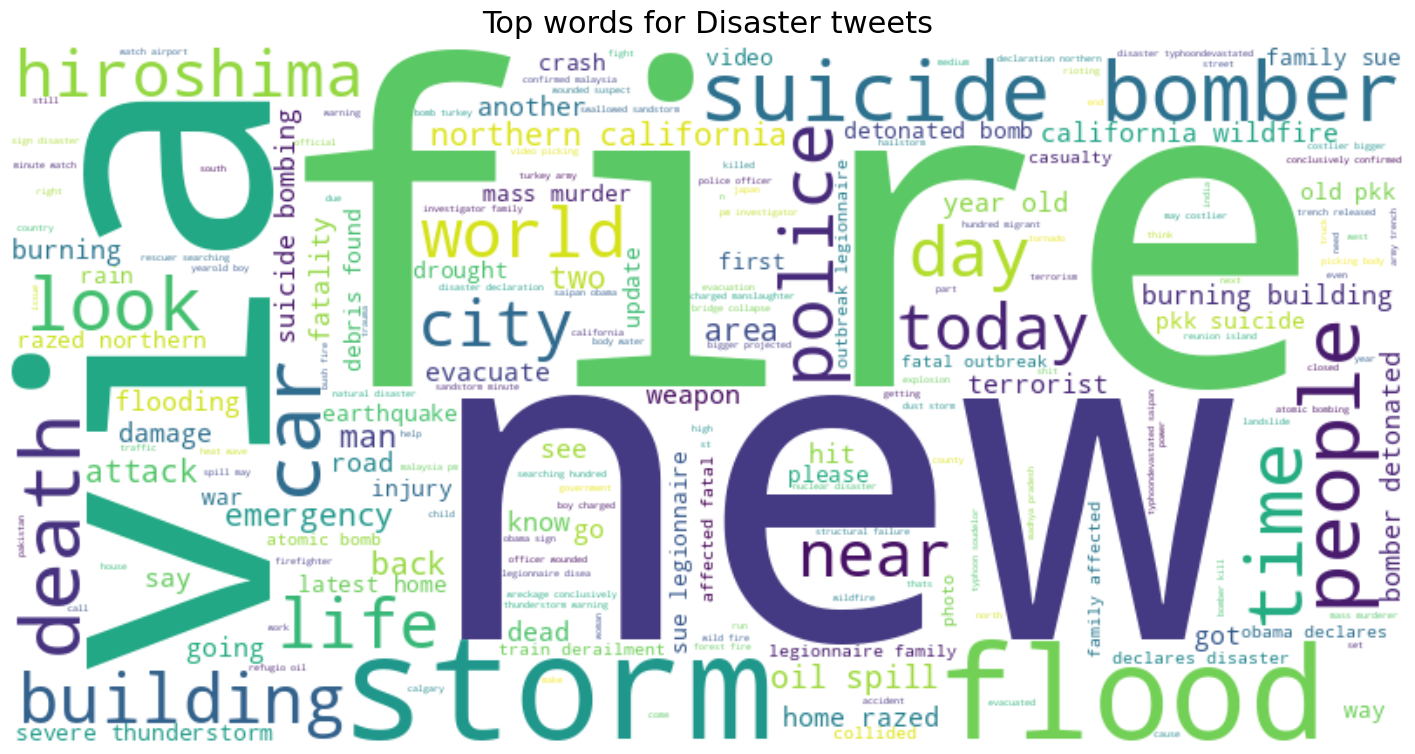

In [ ]:
wc = WordCloud(background_color='white', max_words=200, width=800, height=400)
text = ' '.join(train_dataset.loc[train_dataset['target'] == 1, 'text_clean']) # Generate word cloud with real disaster tweets.
wc.generate(text)

# Configuring and displaying the word cloud
plt.figure(figsize=(18, 10))
plt.title('Top words for Disaster tweets',fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
print(wc.words_.keys())

dict_keys(['new', 'fire', 'via', 'storm', 'flood', 'suicide bomber', 'car', 'people', 'death', 'time', 'police', 'look', 'building', 'day', 'world', 'life', 'hiroshima', 'city', 'near', 'today', 'northern california', 'emergency', 'area', 'two', 'oil spill', 'man', 'back', 'attack', 'california wildfire', 'burning building', 'damage', 'fatality', 'suicide bombing', 'flooding', 'say', 'go', 'year old', 'hit', 'bomber detonated', 'got', 'dead', 'know', 'burning', 'terrorist', 'home razed', 'see', 'road', 'another', 'weapon', 'going', 'evacuate', 'severe thunderstorm', 'mass murder', 'latest home', 'razed northern', 'pkk suicide', 'detonated bomb', 'earthquake', 'rain', 'first', 'injury', 'old pkk', 'update', 'crash', 'please', 'way', 'war', 'video', 'drought', 'debris found', 'family sue', 'sue legionnaire', 'legionnaire family', 'family affected', 'affected fatal', 'fatal outbreak', 'outbreak legionnaire', 'photo', 'casualty', 'collided', 'atomic bomb', 'train derailment', 'obama declar

In [ ]:
corpus_disaster_tweets_fake = build_corpus_from_df(train_dataset, 0)

dic=defaultdict(int)
for word in corpus_disaster_tweets_fake:
    dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('like', 255),
 ('get', 185),
 ('new', 168),
 ('body', 116),
 ('time', 103),
 ('love', 100),
 ('via', 99),
 ('would', 97),
 ('day', 96),
 ('video', 96)]

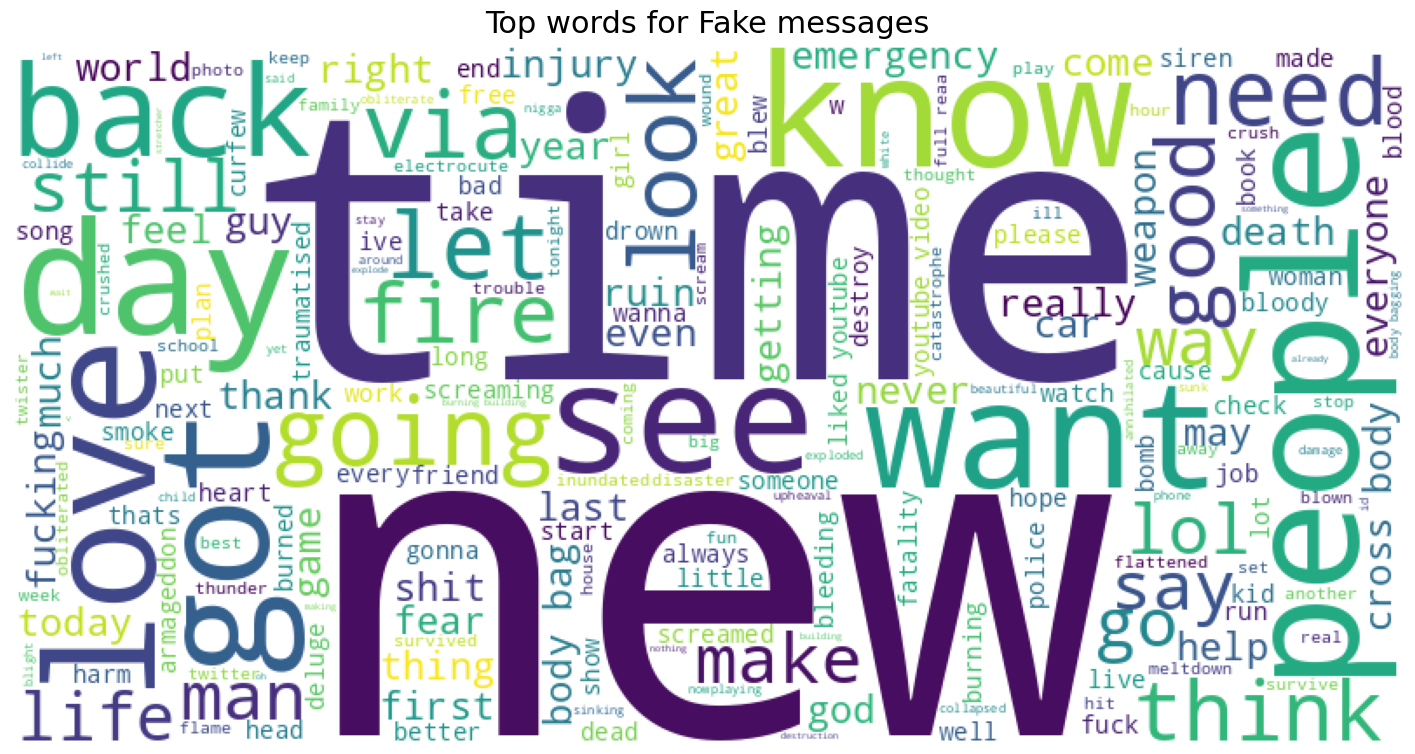

In [ ]:
wc2 = WordCloud(background_color='white',max_words=200,width=800,height=400)
wc2.generate(' '.join(text for text in train_dataset.loc[train_dataset['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Fake messages', fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc2)
plt.axis("off")
plt.show()

In [ ]:
print(wc2.words_.keys())

dict_keys(['new', 'time', 'know', 'day', 'people', 'love', 'see', 'got', 'want', 'back', 'going', 'look', 'let', 'need', 'via', 'think', 'good', 'fire', 'still', 'say', 'man', 'go', 'make', 'lol', 'way', 'life', 'really', 'feel', 'injury', 'thing', 'right', 'help', 'come', 'thank', 'world', 'today', 'great', 'much', 'emergency', 'death', 'body bag', 'fear', 'never', 'year', 'even', 'everyone', 'weapon', 'first', 'game', 'fucking', 'car', 'ruin', 'getting', 'god', 'may', 'cross body', 'shit', 'last', 'guy', 'screaming', 'smoke', 'always', 'check', 'head', 'ive', 'watch', 'youtube video', 'every', 'siren', 'thats', 'please', 'bad', 'liked youtube', 'someone', 'bloody', 'hope', 'better', 'armageddon', 'fuck', 'made', 'work', 'free', 'well', 'gonna', 'girl', 'burning', 'song', 'blew', 'w', 'screamed', 'traumatised', 'plan', 'job', 'run', 'lot', 'little', 'put', 'harm', 'deluge', 'end', 'cause', 'live', 'destroy', 'take', 'start', 'friend', 'show', 'wanna', 'bleeding', 'fatality', 'dead', '

Repeated words

In [ ]:
# Get the words from both word clouds
words_wc2 = set(wc2.words_.keys())
words_wc = set(wc.words_.keys())

common_words = words_wc2.intersection(words_wc)# Find the repeated words in both variables

print(f"Common Words ({len(common_words)}):") # Print common words
print(common_words)

Palabras comunes (57):
{'see', 'end', 'car', 'back', 'day', 'injury', 'right', 'today', 'still', 'new', 'life', 'come', 'look', 'next', 'cause', 'people', 'need', 'death', 'woman', 'know', 'way', 'weapon', 'time', 'emergency', 'burning building', 'year', 'even', 'going', 'say', 'please', 'world', 'getting', 'think', 'man', 'hit', 'via', 'another', 'thats', 'got', 'house', 'help', 'fatality', 'set', 'work', 'photo', 'run', 'building', 'dead', 'fire', 'child', 'make', 'burning', 'damage', 'go', 'police', 'first', 'shit'}
